### week 2

# Additional Notes

In [1]:
import pods
import notebook as nb
import mlai
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

### $f(x|\theta)\ $ or $\ f(x;\theta)\ $?

$x$ is a value of a rv (random variable) $X$, while $\theta$ is a set of parameters

- $f(x;\theta)$ means the probability density of a rv $X$ when it takes a value $x$, with $\theta$ being the parameter of the distribution

- $f(x|y)$ is the conditional probability of a rv $X$ when it takes a value $x$, given a rv $Y$ when it takes a value $y$

### Random Variable and Parameter

(eg) **Gaussian distribution**

Conceptually:
$$
  p(x; \mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(x-\mu)^2}{2\sigma^2} \right)
$$
In practice:
$$
  p(x\ |\ \mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(x-\mu)^2}{2\sigma^2} \right)
$$

### $L^1$-norm and $L^2$-norm

- $L^1$-norm (Manhattan distance, or taxicab geometry)
$$
  ||\mathbf{x}||_1 = |x_1| + \ldots + |x_n|
$$

- $L^2$-norm (Euclidean distance)
$$
  ||\mathbf{x}||_2 = \sqrt{\mathbf{x}^\top\mathbf{x}} = \sqrt{x_1^2 + \ldots + x_n^2}
$$

Wikipedia:
[Taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry) /
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance)

### Noisy Data

(-3, 3)

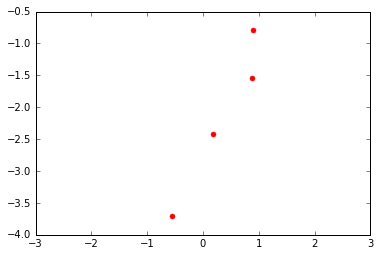

In [10]:
# create four (4) data points
x = np.random.normal(size=4)

# true values
m_true = 1.4
c_true = -3.1

# prediction function with true values
y = m_true * x + c_true

# corrupt them with a bit of Gaussian 'noise' (standard deviation: 0.5)
noise = np.random.normal(scale=0.5, size=4)
y = m_true * x + c_true + noise
plt.plot(x, y, 'r.', markersize=10)
plt.xlim([-3, 3])

### Objective Function using $L^2$-norm

A sum of squared errors between real value $y_i$ and the prediction $f(x_i)$:
$$
    E(m, c) = \sum_{i=1}^n (y_i - f(x_i))^2 = \sum_{i=1}^n (y_i - mx_i - c)^2
$$

### Offset and Slope Gradients

\begin{align}
    \frac{\partial}{\partial c} E(m, c) & = -2\sum_{i=1}^n (y_i - mx_i - c) \\
    \frac{\partial}{\partial m} E(m, c) & = -2\sum_{i=1}^n x_i(y_i - mx_i - c)
\end{align}

### Contour Plot of Objective Function

In [11]:
# create an array of linearly separated values around m_true/c_true
m_vals = np.linspace(m_true-3, m_true+3, 100)
c_vals = np.linspace(c_true-3, c_true+3, 100)

# create a grid of values to evaluate the error function in 2D
m_grid, c_grid = np.meshgrid(m_vals, c_vals)

# compute the error function at each combination of c and m
E_grid = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        E_grid[i, j] = ((y - m_grid[i, j] * x - c_grid[i, j])**2).sum()

# define a function for contour plot
def regression_contour(f, ax, m_vals, c_vals, E_grid):
    hcont = ax.contour(m_vals, c_vals, E_grid, levels=[0, 0.5, 1, 2, 4, 8, 16, 32, 64])
    plt.clabel(hcont, inline=1, fontsize=15)
    ax.set_xlabel('$m$', fontsize=25)
    ax.set_ylabel('$c$', fontsize=25)

### Gradient Descent: Updating $c$ and $m$

The step size is known as the learning rate $\eta$:

\begin{align*}
    c_\text{new} & = c - \eta \frac{\partial}{\partial c} E(m, c) = c + 2\eta\sum_{i=1}^n (y_i - mx_i - c) \\
    m_\text{new} & = m - \eta \frac{\partial}{\partial m} E(m, c) = m + 2\eta\sum_{i=1}^n x_i(y_i - mx_i - c)
\end{align*}

### Gradient at Initial Position

In [12]:
# initial values
m_star = 0.0
c_star = -5.0

# offset and slope gradients
c_grad = -2 * (y - m_star * x - c_star).sum()
m_grad = -2 * (x * (y - m_star * x - c_star)).sum()

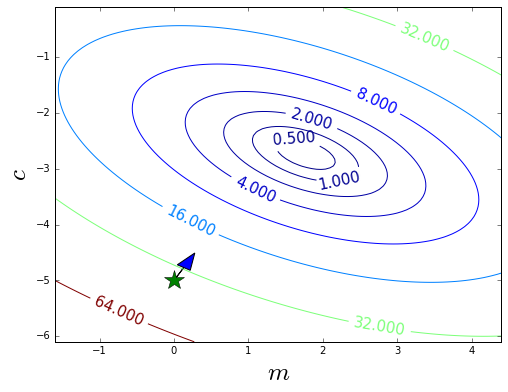

In [14]:
f, ax = plt.subplots(figsize=(8,6))
regression_contour(f, ax, m_vals, c_vals, E_grid)
ax.plot(m_star, c_star, 'g*', markersize=20)  # current position
ax.arrow(m_star, c_star, -m_grad*0.01, -c_grad*0.01, head_width=0.2)  # direction of the gradient

### Stochastic Gradient Descent: Updating $c$ and $m$

Each data point is presented in a random order:

\begin{align}
    c_\text{new} & = c + 2\eta (y_i - mx_i - c) \\
    m_\text{new} & = m + 2\eta x_i (y_i - mx_i - c)
\end{align}

In [ ]:
def objective_gradient(Y, U, V):
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    for ind, series in Y.iterrows():
        film = series['index']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film]) 
        diff = prediction - rating
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
    return obj, gU, gV

learn_rate = 0.01
iterations = 100
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("iteration", i+1, " objective function:", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV

In [ ]:
def stochastic_gradient(Y, U, V, learn_rate):
    Y = Y.iloc[np.random.permutation(len(Y))]  # shuffling the dataset
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    for ind, series in Y.iterrows():
        film = series['index']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film])
        diff = prediction - rating
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]  # accumulating gradients
        gV.loc[film] += 2*diff*U.loc[user]
        U.loc[user] -= learn_rate*gU.loc[user]  # updating parameters
        V.loc[film] -= learn_rate*gV.loc[film]
    return obj, gU, gV

learn_rate = 0.01
iterations = 100
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V, learn_rate)
    print("iteration", i+1, " objective function:", obj)

In [ ]:
def stochastic_gradient(Y, U, V, learn_rate):
    Y = Y.iloc[np.random.permutation(len(Y))]  # shuffling the dataset
    obj = 0.
    for ind, series in Y.iterrows():
        film = series['index']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film])
        diff = prediction - rating
        obj += diff*diff
        U.loc[user] -= learn_rate*2*diff*V.loc[film]  # updating parameters
        V.loc[film] -= learn_rate*2*diff*U.loc[user]
    return obj, U, V

learn_rate = 0.01
iterations = 100
for i in range(iterations):
    obj, U, V = objective_gradient(Y, U, V, learn_rate)
    print("iteration", i+1, " objective function:", obj)